##### - The idea is to optimize multiple models and use a VotingClassifier to determine the best result.
##### - Models: RandomForestClassifier, GradientBoostingClassifier, SVC

In [2]:
# imports

from imblearn.pipeline import Pipeline  # Note: using the Pipeline from imblearn here.
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline # Pipeline from sklearn
from sklearn.compose import ColumnTransformer #possibly for additional preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,PowerTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

In [3]:
pd.set_option('display.max_colwidth', None) #to display all columns

dataset = load_breast_cancer()
df = pd.DataFrame(dataset["data"],columns=dataset["feature_names"])
df["target"] = dataset["target"]
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [4]:
# in case preprocessing is needed later:
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), ['feature1', 'feature2', 'feature3']),
#     # Add more transformations here
# ])

In [5]:
# Separate features and target
X = df.drop("target",axis=1)
y = df["target"] 

In [6]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)
print(f"Training dataset shape:{X_train.shape}")
print(f"Test dataset shape:{X_test.shape}")

Trainingsdatensatz Shape:(455, 30)
Testdatensatz Shape:(114, 30)


In [7]:
### IMPORTANT: invert logic! 0 = benign, 1 = malignant
y_test = 1 - y_test
y_train = 1 - y_train 


In [8]:
# use half of the available CPU cores
# cpu_cores = int((multiprocessing.cpu_count())/2)
cpu_cores = 8

In [33]:
# SVC
pipeline_svc = Pipeline([("scaler", StandardScaler()),("svc" ,SVC(probability=True))]) #pipeline consisting of scaling and SVC with probability enabled

#all parameters to evaluate (naming syntax scv__xxxxx is important)
param_grid = {
    "scaler" : [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(method='yeo-johnson'), "passthrough"],
    'svc__kernel': ['linear', 'rbf'],    
    # 'svc__C': [0.01, 0.05, 0.1, 1, 10, 100, 200, 500], #optionally remove the lower values to avoid overfitting [0.05,0.1, 1, 10, 100, 200]            
    # 'svc__gamma': [50, 20 ,10, 1, 0.1, 0.01, 0.001, 0.0001], #optionally remove the lower values to avoid overfitting [20 ,10, 1, 0.1, 0.01, 0.001]
    'svc__C': [0.1, 1, 10, 100, 200],                 
    'svc__gamma': [10, 1, 0.1, 0.01, 0.001],
    'svc__class_weight': ['balanced', {0:1, 1:1.5}] #[None, 'balanced', {0:1, 1:1.5}]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)

#or directly optimize with scoring="recall"
gs_svc = GridSearchCV(pipeline_svc, param_grid, scoring=fb_scorer, cv=5, verbose=2, n_jobs=cpu_cores) 
gs_svc.fit(X_train,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=8,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler(), PowerTransformer(),
                                    'passthrough'],
                         'svc__C': [0.1, 1, 10, 100, 200],
                         'svc__class_weight': ['balanced', {0: 1, 1: 1.5}],
                         'svc__gamma': [10, 1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=50),
             verbose=2)

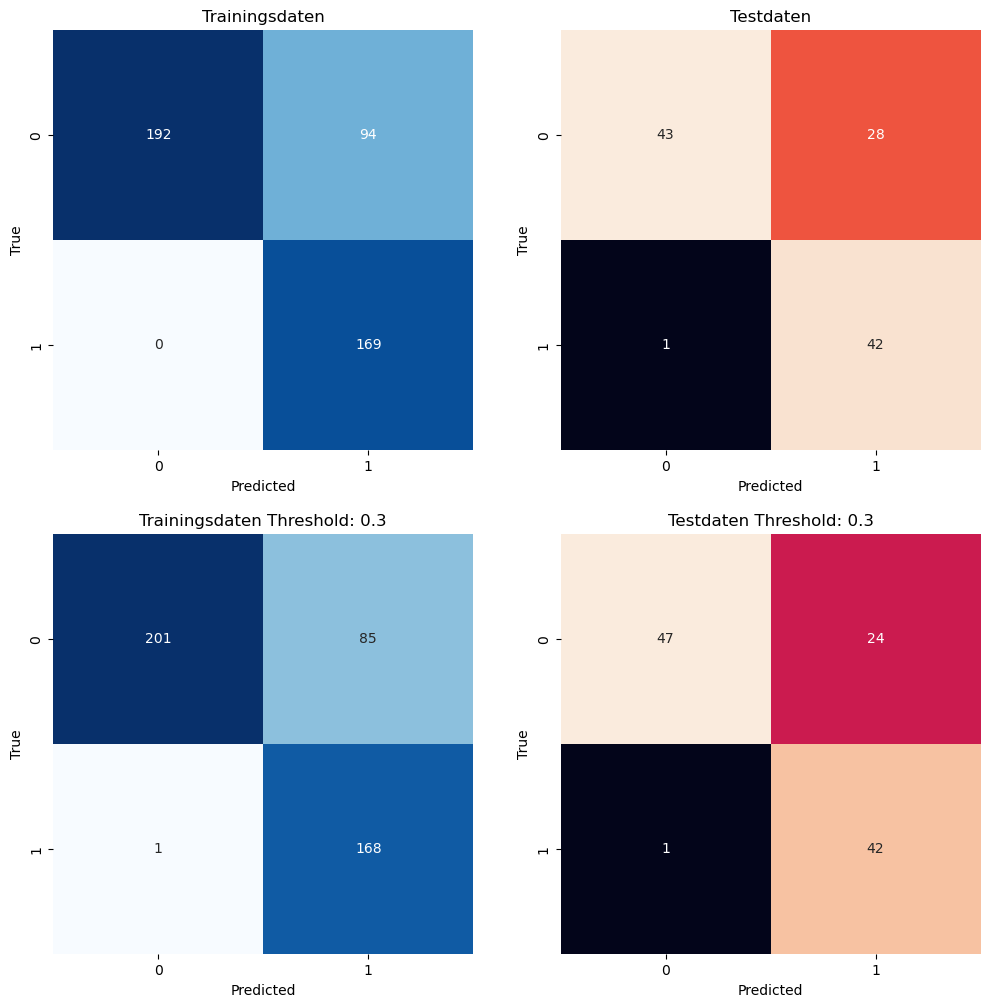

In [70]:
best_SVC = gs_svc.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#Training data
SVC_train_pred = best_SVC.predict(X_train)
sns.heatmap(confusion_matrix(y_train, SVC_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

#Test data
SVC_test_pred = best_SVC.predict(X_test)
sns.heatmap(confusion_matrix(y_test, SVC_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

SVC_threshold = 0.3 ### <-- set threshold
###SVC uses different methods for probability in predict() and predict_proba()
### --> the thresholds are not comparable -> e.g. 0.5 != 0.5


#Training data (Threshold Tuning)
SVC_train_proba = best_SVC.predict_proba(X_train)[:, 1]
SVC_train_proba_pred = (SVC_train_proba >= SVC_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, SVC_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {SVC_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

#Test data (Threshold Tuning)
SVC_test_proba = best_SVC.predict_proba(X_test)[:, 1]
SVC_test_proba_pred = (SVC_test_proba >= SVC_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, SVC_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {SVC_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

#plt.tight_layout()
plt.show()

### Next: Random Forest 

In [35]:
# Random Forest
pipeline_rf = Pipeline([("rf" ,RandomForestClassifier())]) #the pipeline initially only contains the random forest "rf"

param_grid = {
    'rf__n_estimators': [200, 300, 500], #[100, 200, 300, 500]     # number of trees in the forest
    'rf__max_depth': [10, 20, 30, 40], #None, 50           # maximum depth of individual trees
    'rf__min_samples_split': [5, 10, 20],  #[2, 5, 10]               # minimum number of samples to allow a split
    'rf__min_samples_leaf': [4, 6 ,10],    #[1, 2, 4]          # minimum samples that must be in a leaf
    'rf__max_features': ['sqrt', 'log2'],               # number of features considered at each split
    'rf__bootstrap': [True], #False wegen overfitting entfernt [True, False]   # whether bootstrap samples should be used
    'rf__criterion': ['gini', 'entropy'],                # criterion to measure split quality
    'rf__class_weight': ['balanced', {0:1, 1:1.5}]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)

#or directly optimize with scoring="recall"
gs_rf = GridSearchCV(pipeline_rf, param_grid, scoring="recall", cv=6, verbose=2, n_jobs=cpu_cores) 
gs_rf.fit(X_train,y_train)

Fitting 6 folds for each of 864 candidates, totalling 5184 fits


GridSearchCV(cv=6, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'rf__bootstrap': [True],
                         'rf__class_weight': ['balanced', {0: 1, 1: 1.5}],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [10, 20, 30, 40],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [4, 6, 10],
                         'rf__min_samples_split': [5, 10, 20],
                         'rf__n_estimators': [200, 300, 500]},
             scoring='recall', verbose=2)

In [36]:
print(gs_rf.best_params_)

{'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}


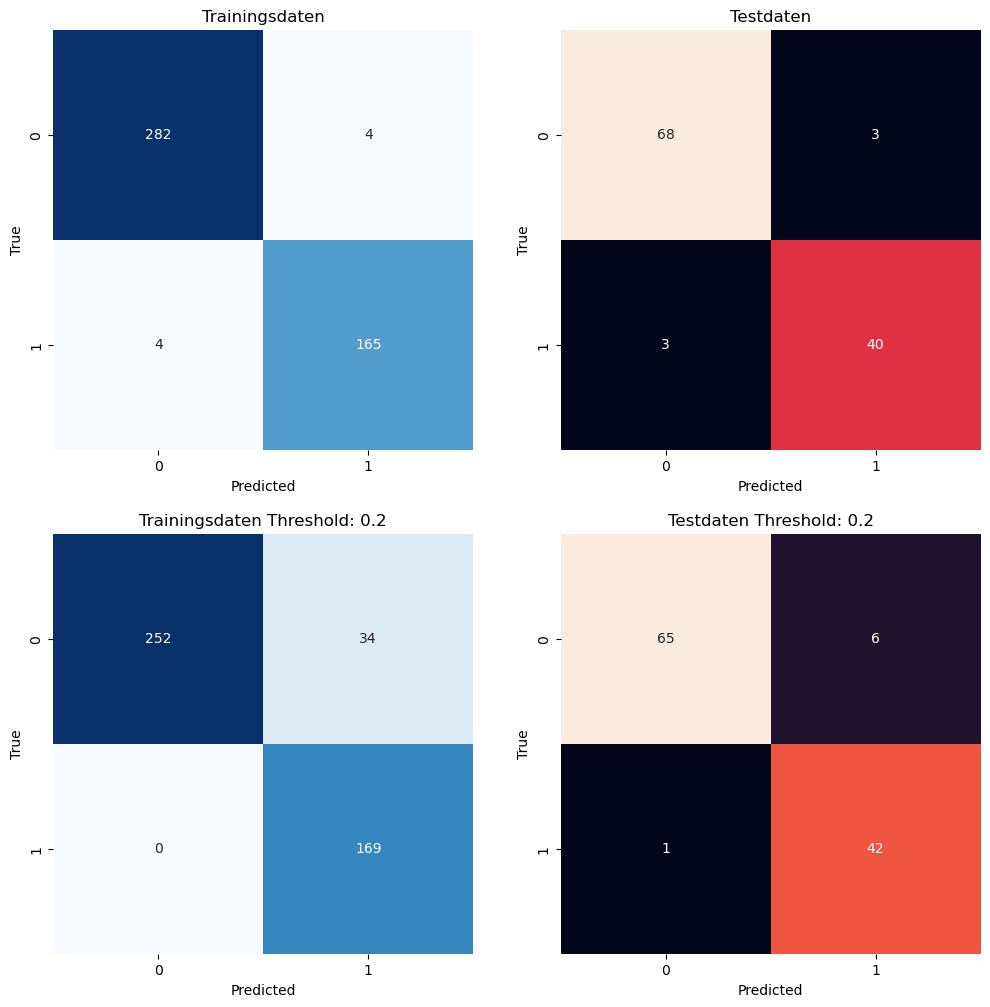

In [69]:
best_RF = gs_rf.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#Training data
RF_train_pred = best_RF.predict(X_train)
sns.heatmap(confusion_matrix(y_train, RF_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

#Test data
RF_test_pred = best_RF.predict(X_test)
sns.heatmap(confusion_matrix(y_test, RF_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

RF_threshold = 0.2 ### <-- set threshold

#Training data (Threshold Tuning)
RF_train_proba = best_RF.predict_proba(X_train)[:, 1]
RF_train_proba_pred = (RF_train_proba >= RF_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, RF_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {RF_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

#Test data (Threshold Tuning)
RF_test_proba = best_RF.predict_proba(X_test)[:, 1]
RF_test_proba_pred = (RF_test_proba >= RF_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, RF_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {RF_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

#plt.tight_layout()
plt.show()

### And as a third model: a Neural Network (MLP)

In [44]:
# MLP (shallow neural network)
#pipeline = Pipeline([("scaler", StandardScaler()),("mlp" ,MLPClassifier())]) #pipeline consisting of scaling and MLP
pipeline_mlp = Pipeline([("smote", SMOTE()),("scaler", StandardScaler()),("mlp" ,MLPClassifier())]) #pipeline consisting of scaling and MLP

#all parameters to evaluate (naming syntax MLP__xxxxx is important)
param_grid = {
    "smote": [SMOTE(sampling_strategy='auto', random_state=42), "passthrough"], #[SMOTE(sampling_strategy='auto', random_state=42), "passthrough"]
    "scaler": [RobustScaler()], # [StandardScaler(), MinMaxScaler(), RobustScaler()]
    "mlp__hidden_layer_sizes": [(50, 50), (100, 50), (100, 100)], #[(50,), (100,), (50, 50), (100, 50), (100, 100), (100, 50, 25)]
    "mlp__activation": ['relu', 'tanh', 'logistic'],
    "mlp__solver": ['adam', 'sgd','lbfgs'],
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.05],
    "mlp__learning_rate_init": [0.001, 0.01, 0.1, 0.5],
    "mlp__max_iter": [200, 500]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)



#or directly optimize with scoring="recall"
gs_mlp = GridSearchCV(pipeline_mlp, param_grid, scoring="recall", cv=5, verbose=2, n_jobs=cpu_cores) 
gs_mlp.fit(X_train,y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=8,
             param_grid={'mlp__activation': ['relu', 'tanh', 'logistic'],
                         'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
                         'mlp__hidden_layer_sizes': [(50, 50), (100, 50),
                                                     (100, 100)],
                         'mlp__learning_rate_init': [0.001, 0.01, 0.1, 0.5],
                         'mlp__max_iter': [200, 500],
                         'mlp__solver': ['adam', 'sgd', 'lbfgs'],
                         'scaler': [RobustScaler()],
                         'smote': [SMOTE(random_state=42), 'passthrough']},
             scoring='recall', verbose=2)

In [45]:
print(gs_mlp.best_params_)

{'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 500, 'mlp__solver': 'sgd', 'scaler': RobustScaler(), 'smote': SMOTE(random_state=42)}


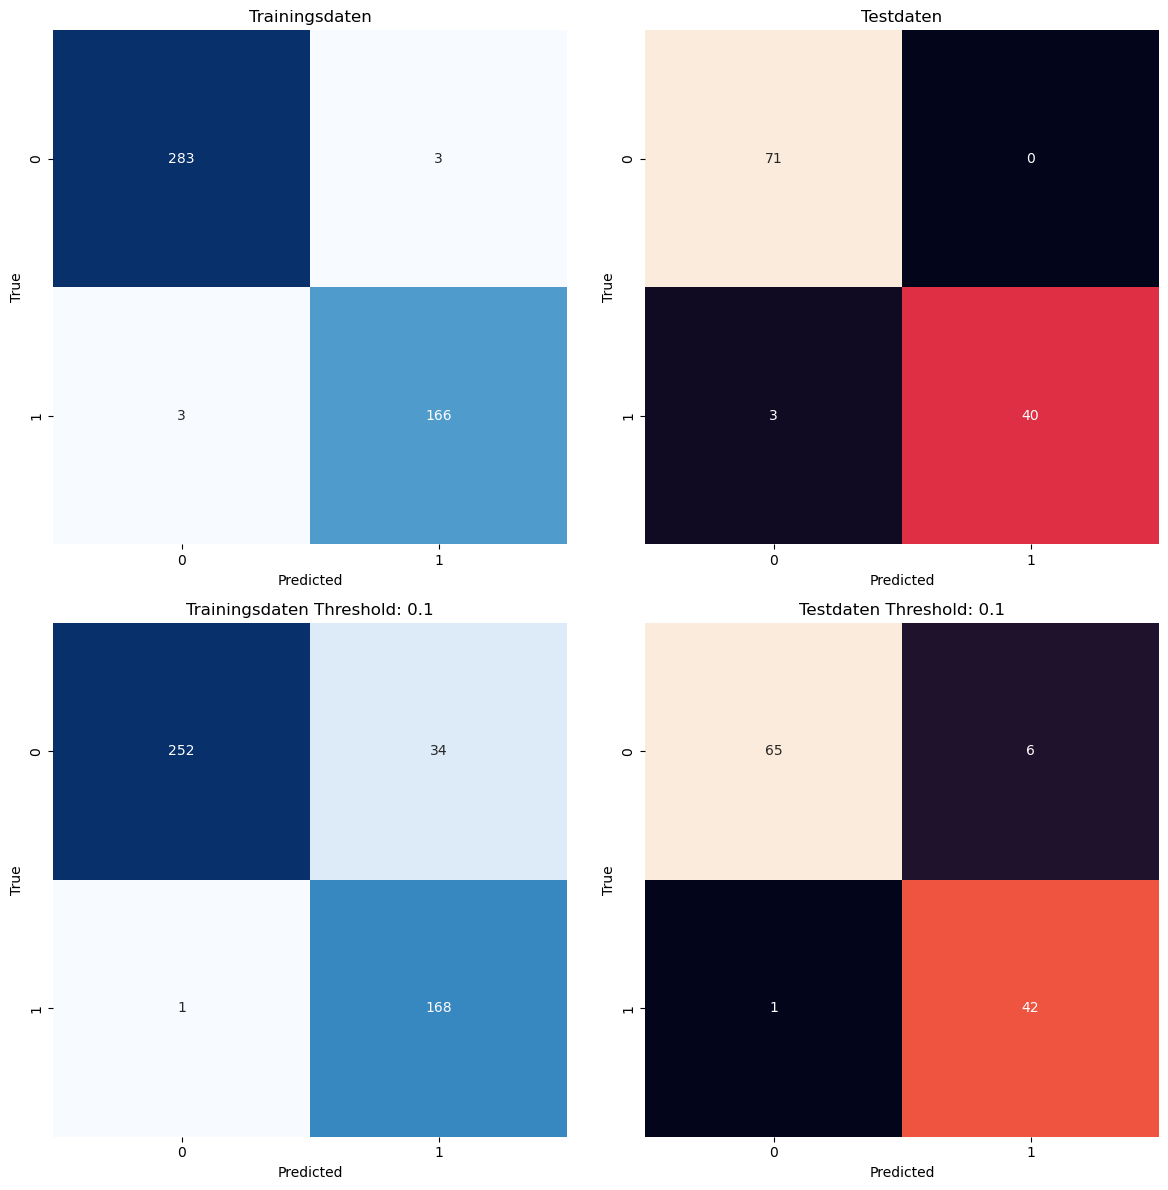

In [68]:
best_MLP = gs_mlp.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Training data (Default Threshold)
MLP_train_pred = best_MLP.predict(X_train)
sns.heatmap(confusion_matrix(y_train, MLP_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

# Test data (Default Threshold)
MLP_test_pred = best_MLP.predict(X_test)
sns.heatmap(confusion_matrix(y_test, MLP_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

MLP_threshold = 0.1  ### <-- set threshold

# Training data (Threshold Tuning)
MLP_train_proba = best_MLP.predict_proba(X_train)[:, 1]
MLP_train_proba_pred = (MLP_train_proba >= MLP_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, MLP_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {MLP_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

# Test data (Threshold Tuning)
MLP_test_proba = best_MLP.predict_proba(X_test)[:, 1]
MLP_test_proba_pred = (MLP_test_proba >= MLP_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, MLP_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {MLP_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

plt.tight_layout()
plt.show()

In [54]:
# VotingClassifier erstellen – soft voting, damit die Wahrscheinlichkeiten gemittelt werden
voting_clf = VotingClassifier(
    estimators=[
        ("svc", best_SVC),
        ("rf", best_RF),
        ("mlp", best_MLP)
    ],
    voting='soft'
)

# VotingClassifier auf den Training data anpassen
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('scaler', 'passthrough'),
                                              ('svc',
                                               SVC(C=0.1,
                                                   class_weight='balanced',
                                                   gamma=0.001,
                                                   probability=True))])),
                             ('rf',
                              Pipeline(steps=[('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=10,
                                                                      min_samples_leaf=6,
                                                                      min_samples_split=10,
                                                                      n_estimators=300))])),
                             ('mlp',
                              Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                              ('scaler', RobustScaler()),
                                              ('mlp',
                                               MLPClassifier(hidden_layer_sizes=(100,
                                                                                 50),
                                                             max_iter=500,
                                                             solver='sgd'))]))],
                 voting='soft')

In [55]:
## Voting results for the training data
y_train_pred = voting_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       286
           1       0.98      0.99      0.99       169

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455

[[283   3]
 [  2 167]]


In [56]:
## Voting results for the test data
y_test_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

[[68  3]
 [ 1 42]]


### This is not ideal
#### Thresholds must be taken into account:

SVC Schwelle: 0.3
RF Schwelle: 0.2
MLP Schwelle: 0.1


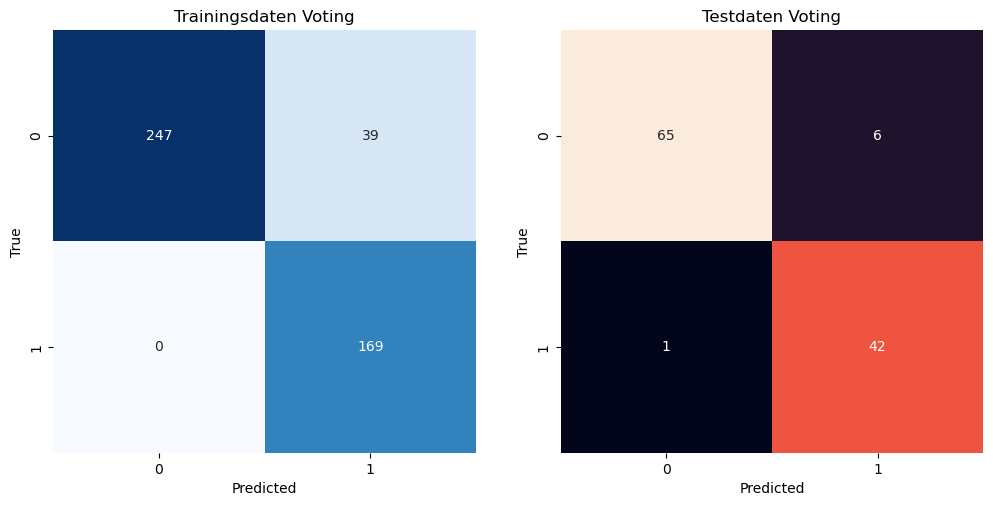

In [87]:
### Basically all required variables have already been calculated:

print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

# Number of required votes:
s = 2

#für die Training data:
vote_train_pred = (SVC_train_proba_pred + RF_train_proba_pred + MLP_train_proba_pred) >= s
vote_train_pred = vote_train_pred.astype(int)

# für die Test data:
vote_test_pred = (SVC_test_proba_pred + RF_test_proba_pred + MLP_test_proba_pred) >= s
vote_test_pred = vote_test_pred.astype(int)

# confusion matrix:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_train, vote_train_pred),cmap='Blues', annot=True, fmt="d", cbar=False, square=True, ax=axes[0])
axes[0].set_title("Training data Voting")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, vote_test_pred), annot=True, fmt="d", cbar=False, square=True, ax=axes[1])
axes[1].set_title("Test data Voting")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [128]:
### Die Wahrscheinlichekeiten addieren und vergleichen:

vote_train_proba = (SVC_train_proba + RF_train_proba + MLP_train_proba) / 3
vote_test_proba = (SVC_test_proba + RF_test_proba + MLP_test_proba) / 3

#First compare the probabilities side by side
df_vote_train_proba = pd.DataFrame({
    "SVC_train_proba": SVC_train_proba,
    "RF_train_proba": RF_train_proba,
    "MLP_train_proba": MLP_train_proba,
    "vote_train_proba": vote_train_proba
})

df_vote_test_proba = pd.DataFrame({
    "SVC_test_proba": SVC_test_proba,
    "RF_test_proba": RF_test_proba,
    "MLP_test_proba": MLP_test_proba,
    "vote_test_proba": vote_test_proba
})


In [129]:
df_vote_train_proba.describe()

,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba
count,455.000000,455.000000,455.000000,455.000000
mean,0.428876,0.385839,0.378627,0.397781
std,0.296855,0.431677,0.453659,0.383527
min,0.024295,0.000000,0.000002,0.009663
25%,0.133703,0.008625,0.003271,0.054921
50%,0.395411,0.103328,0.038200,0.180447
75%,0.748628,0.943348,0.986988,0.895933
max,0.822471,1.000000,1.000000,0.940684


In [130]:
df_vote_test_proba.describe()

,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba
count,114.000000,114.000000,114.000000,114.000000
mean,0.414273,0.377535,0.369077,0.386962
std,0.271150,0.435605,0.458280,0.374266
min,0.030668,0.000000,0.000016,0.012496
25%,0.124506,0.012372,0.003290,0.051434
50%,0.408148,0.057284,0.024030,0.149172
75%,0.683201,0.955622,0.994919,0.887355
max,0.802161,1.000000,1.000000,0.929313


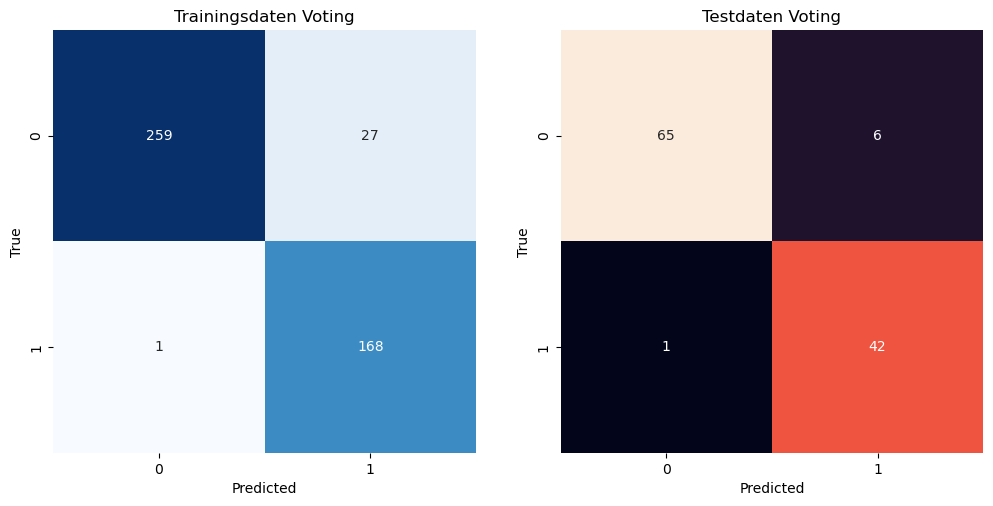

In [175]:
### now apply thresholds for the overall probability in a confusion matrix:

#threshold
S = 0.3

#calculate predictions:
vote_train_proba_pred = vote_train_proba >= S
vote_train_proba_pred = vote_train_proba_pred.astype(int)

vote_test_proba_pred = vote_test_proba >= S
vote_test_proba_pred = vote_test_proba_pred.astype(int)


# confusion matrix:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_train, vote_train_proba_pred),cmap='Blues', annot=True, fmt="d", cbar=False, square=True, ax=axes[0])
axes[0].set_title("Training data Voting")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, vote_test_proba_pred), annot=True, fmt="d", cbar=False, square=True, ax=axes[1])
axes[1].set_title("Test data Voting")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [191]:
# DataFrame with all training predictions:
df_all_train_predictions = pd.DataFrame({
    "SVC_train_pred": SVC_train_pred,
    "RF_train_pred": RF_train_pred,
    "MLP_train_pred": MLP_train_pred,
    "SVC_train_proba_pred": SVC_train_proba_pred,
    "RF_train_proba_pred": RF_train_proba_pred,
    "MLP_train_proba_pred": MLP_train_proba_pred,
    "vote_train_pred": vote_train_pred,
    "SVC_train_proba": SVC_train_proba,
    "RF_train_proba": RF_train_proba,
    "MLP_train_proba": MLP_train_proba,
    "vote_train_proba": vote_train_proba,
    "vote_train_proba_pred": vote_train_proba_pred,
    "TARGET": y_train
}) 

# DataFrame with all test predictions:
df_all_test_predictions = pd.DataFrame({
    "SVC_test_pred": SVC_test_pred,
    "RF_test_pred": RF_test_pred,
    "MLP_test_pred": MLP_test_pred,
    "SVC_test_proba_pred": SVC_test_proba_pred,
    "RF_test_proba_pred": RF_test_proba_pred,
    "MLP_test_proba_pred": MLP_test_proba_pred,
    "vote_test_pred": vote_test_pred,
    "SVC_test_proba": SVC_test_proba,
    "RF_test_proba": RF_test_proba,
    "MLP_test_proba": MLP_test_proba,
    "vote_test_proba": vote_test_proba,
    "vote_test_proba_pred": vote_test_proba_pred,
    "TARGET": y_test
})


In [192]:
print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

print(f"s (number of required votes) is: {s}")
print(f"S (threshold for probabilities) is: {S}")

df_all_train_predictions.head(20)

SVC Schwelle: 0.3
RF Schwelle: 0.2
MLP Schwelle: 0.1
s (number of required votes) is: 2
S (threshold for probabilities) is: 0.3


,SVC_train_pred,RF_train_pred,MLP_train_pred,SVC_train_proba_pred,RF_train_proba_pred,MLP_train_proba_pred,vote_train_pred,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba,vote_train_proba_pred,TARGET
31,1,1,1,1,1,1,1,0.749356,0.906531,0.989548,0.881812,1,1
77,1,1,1,1,1,1,1,0.749999,0.917050,0.999853,0.888967,1,1
40,1,0,0,1,1,1,1,0.787795,0.334025,0.155367,0.425729,1,1
519,0,0,0,0,0,0,0,0.134069,0.006948,0.031126,0.057381,0,0
215,1,1,1,1,1,1,1,0.619335,0.776289,0.701805,0.699143,1,1
418,0,0,0,0,0,0,0,0.087462,0.000843,0.001858,0.030054,0,0
555,0,0,0,0,0,0,0,0.183189,0.055088,0.015298,0.084525,0,0
167,1,1,1,1,1,1,1,0.758195,0.972775,0.982143,0.904371,1,1
366,1,1,1,1,1,1,1,0.760673,1.000000,0.999985,0.920220,1,1
204,1,0,0,1,0,1,1,0.600345,0.037354,0.131390,0.256363,0,0


In [193]:
df_train_abweichungen = df_all_train_predictions[df_all_train_predictions["vote_train_proba_pred"] != df_all_train_predictions["TARGET"]]
df_train_abweichungen

,SVC_train_pred,RF_train_pred,MLP_train_pred,SVC_train_proba_pred,RF_train_proba_pred,MLP_train_proba_pred,vote_train_pred,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba,vote_train_proba_pred,TARGET
347,1,0,0,1,1,0,1,0.545802,0.292916,0.071597,0.303438,1,0
508,1,0,0,1,1,1,1,0.655844,0.408259,0.128291,0.397465,1,0
421,1,0,0,1,1,1,1,0.596967,0.471166,0.166391,0.411508,1,0
157,1,1,1,1,1,1,1,0.634790,0.677658,0.558805,0.623751,1,0
406,1,0,0,1,1,1,1,0.651816,0.477524,0.139235,0.422858,1,0
209,1,0,0,1,1,0,1,0.704256,0.408327,0.027010,0.379864,1,0
135,1,0,0,1,1,1,1,0.352995,0.226474,0.116599,0.232023,0,1
128,1,0,0,1,1,1,1,0.523882,0.486197,0.250435,0.420171,1,0
375,1,0,0,1,1,0,1,0.655826,0.390295,0.080490,0.375537,1,0
112,1,1,0,1,1,0,1,0.554808,0.545168,0.040843,0.380273,1,0


In [195]:
print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

print(f"s (number of required votes) is: {s}")
print(f"S (threshold for probabilities) is: {S}")

df_all_test_predictions.head(20)

SVC Schwelle: 0.3
RF Schwelle: 0.2
MLP Schwelle: 0.1
s (number of required votes) is: 2
S (threshold for probabilities) is: 0.3


,SVC_test_pred,RF_test_pred,MLP_test_pred,SVC_test_proba_pred,RF_test_proba_pred,MLP_test_proba_pred,vote_test_pred,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba,vote_test_proba_pred,TARGET
123,1,0,0,1,1,0,1,0.553263,0.301512,0.024191,0.292989,0,0
30,1,1,1,1,1,1,1,0.707364,1.000000,0.999994,0.902453,1,1
370,1,1,1,1,1,1,1,0.722213,0.999395,0.999466,0.907025,1,1
262,1,1,1,1,1,1,1,0.743168,0.965301,0.996586,0.901685,1,1
89,1,1,0,1,1,1,1,0.608682,0.565662,0.329423,0.501256,1,0
350,0,0,0,0,0,0,0,0.061333,0.000000,0.001317,0.020883,0,0
224,1,0,0,1,0,0,0,0.330287,0.034460,0.027692,0.130813,0,0
480,0,0,0,0,0,0,0,0.040857,0.000649,0.006403,0.015970,0,0
267,0,0,0,0,0,0,0,0.238513,0.043616,0.016429,0.099519,0,0
59,1,0,0,1,0,0,0,0.432807,0.009136,0.000158,0.147367,0,0


In [ ]:
df_test_abweichungen = df_all_test_predictions[df_all_test_predictions["vote_test_proba_pred"] != df_all_test_predictions["TARGET"]]
df_test_abweichungen

,SVC_test_pred,RF_test_pred,MLP_test_pred,SVC_test_proba_pred,RF_test_proba_pred,MLP_test_proba_pred,vote_test_pred,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba,vote_test_proba_pred,TARGET
89,1,1,0,1,1,1,1,0.608682,0.565662,0.329423,0.501256,1,0
148,1,1,0,1,1,1,1,0.603855,0.562339,0.142906,0.436367,1,0
297,0,0,0,0,0,0,0,0.240358,0.065941,0.007199,0.104499,0,1
481,1,0,0,1,0,0,0,0.783236,0.151273,0.053532,0.329347,1,0
476,1,0,0,1,1,1,1,0.768379,0.370212,0.208604,0.449065,1,0
363,1,1,0,1,1,1,1,0.686801,0.699424,0.361855,0.582693,1,0
448,1,0,0,1,1,1,1,0.527642,0.289613,0.214609,0.343955,1,0
